In [1]:
import random, os, time
from pathlib import Path
import numpy  as np
import csv
from tqdm import tqdm

# do this before importing tensorflow to get rid of annoying warning messages
import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import ResNet50V2 
import matplotlib.pyplot as plt

#### Read left-right pairs from csv file

In [10]:
file = open('COMP90086_2023_TLLdataset/train.csv')
csvreader = csv.reader(file)
header = next(csvreader) # skip header
pairs = []
for row in csvreader:
    pairs.append(row)
file.close()

In [9]:
def convert_to_path(pairs):
    pair_paths = []
    for pair in pairs:
        left_img_path = 'COMP90086_2023_TLLdataset/train/left/' + pair[0] + '.jpg'
        right_img_path = 'COMP90086_2023_TLLdataset/train/right/' + pair[1] + '.jpg'
        pair_paths.append([left_img_path, right_img_path])
    return pair_paths    


In [11]:
pairs = convert_to_path(pairs)

In [12]:
pairs[0]

['COMP90086_2023_TLLdataset/train/left/aaa.jpg',
 'COMP90086_2023_TLLdataset/train/right/osr.jpg']

#### Load images and perform preprocessing

In [13]:
"""
    load image jpeg image from file and resize into the target shape
"""
def preprocess_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    #img = tf.image.resize(img, target_shape)
    return img

""" 
    preprocess a triplet of images given their filenames
"""
def preprocess_triplets(anchor, positive, negative):
    return (preprocess_image(anchor), preprocess_image(positive), preprocess_image(negative))

In [14]:
# load anchor and positive images (make sure they're in the right order) 
anchor_images = [pair[0] for pair in pairs]
positive_images = [pair[1] for pair in pairs]
image_count = len(anchor_images)

# split into training and validation sets
num_train = int(0.8*image_count)
num_val = image_count - num_train
anchor_images_train = anchor_images[:num_train]
anchor_images_val = anchor_images[num_train:]
positive_images_train = positive_images[:num_train]
positive_images_val = positive_images[num_train:]

#### Functions for generating dataset of triplets. Each triplet contains: (anchor_image, positive_image, negative_image)

In [15]:
def generate_triplets_randomly(anchors, positives, num_negatives):
    
    # first combine the anchor and positive image sets and shuffle it up
    negatives = anchors + positives
    np.random.RandomState(seed=32).shuffle(negatives)
    
    # now, randomly sample num_negatives+2 negative images for each anchor
    # (we sample an extra two images in case there are duplicates
    # of the positive or anchor image in the negative images set)
    triplets = []
    for i in range(0, len(anchors)):
        # randomly sample num_negatives+2 images without replacement
        negative_set = random.sample(negatives, num_negatives+2)
        # remove any duplicates
        negative_set = [img for img in negative_set if img != anchors[i] and img != positives[i]] 
        negative_set = negative_set[:num_negatives]

        for negative_img in negative_set:
            triplets.append((anchors[i], positives[i], negative_img))    


    # shuffle the triplet set
    np.random.RandomState(seed=2).shuffle(triplets)

    triplet_anchors = [t[0] for t in triplets]
    triplet_positives = [t[1] for t in triplets]
    triplet_negatives = [t[2] for t in triplets]

    return (triplet_anchors, triplet_positives, triplet_negatives)


# instead of picking negative images randomly, can use the distance metric to find the most similar negative images to the anchor and positive
# these are the so-called "hard negatives"
#def generate_triplets_randomly_hard_negatives():
#    ...
    


def create_tf_dataset_triplets(anchors, positives, negatives, batch_size):
    # create tensorflow datasets
    anchor_dataset = tf.data.Dataset.from_tensor_slices(anchors)
    positive_dataset = tf.data.Dataset.from_tensor_slices(positives)
    negative_dataset = tf.data.Dataset.from_tensor_slices(negatives)
    
    # create a triplet dataset
    dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
    dataset = dataset.shuffle(buffer_size=1024)


    # convert filenames to preprocessed images
    dataset = dataset.map(preprocess_triplets) #, num_parallel_calls=tf.data.AUTOTUNE) 
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE) #(32) 

    return dataset
        

#### Generate training and validation batched tensorflow datasets

In [16]:
num_negatives = 10 # number of negative images per left-right pior
batch_size = 32

# training set triplets
(anchor_train, positive_train, negative_train) = generate_triplets_randomly(anchor_images_train, positive_images_train, num_negatives)
# validation set triplets
(anchor_val, positive_val, negative_val) = generate_triplets_randomly(anchor_images_val, positive_images_val, num_negatives)

# create tensorflow datasets
triplets_train = create_tf_dataset_triplets(anchor_train, positive_train, negative_train, batch_size=batch_size)
triplets_val = create_tf_dataset_triplets(anchor_val, positive_val, negative_val, batch_size=batch_size)

#### Visualize the training data

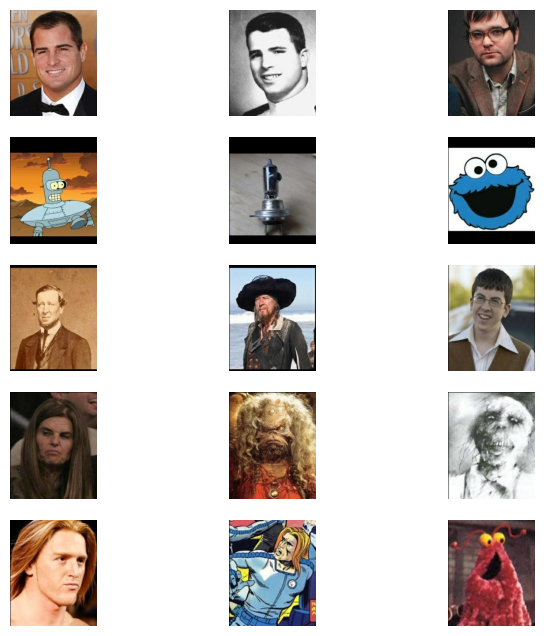

In [19]:
def visualize(anchor, positive, negative_set):
    
    def show(ax, image):
        ax.imshow(image)
        ax.axis('off')
        

    fig = plt.figure(figsize=(8, 8))
    axs = fig.subplots(5, 3)
        
    for i in range(5):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative_set[i])


visualize(*list(triplets_train.take(1).as_numpy_iterator())[0])
